# Merging AR and 2ndMOA of forewing sampled from PC axes to other wing characters from WingCharacters.ipynb

In [32]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from PIL import Image
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [33]:
png12_files = [f'./PC_axis12/{f}' for f in os.listdir('PC_axis12') if f.lower().endswith('fw.png')]
png13_files = [f'./PC_axis13/{f}' for f in os.listdir('PC_axis13') if f.lower().endswith('fw.png')]
png23_files = [f'./PC_axis23/{f}' for f in os.listdir('PC_axis23') if f.lower().endswith('fw.png')]

In [34]:
target_axes = 4

In [35]:
if target_axes == 1:
    png_files = png12_files + png13_files
if target_axes == 2:
    png_files = png12_files + png23_files
if target_axes == 3:
    png_files = png23_files + png13_files
if target_axes == 4:
    png_files = png12_files + png13_files + png23_files

In [36]:
png_files.sort()

In [37]:
len(png_files)

27

In [38]:
png_files[-5:]

['./PC_axis23/xy_0_0_FW.png',
 './PC_axis23/xy_0_3_FW.png',
 './PC_axis23/xy_3_-3_FW.png',
 './PC_axis23/xy_3_0_FW.png',
 './PC_axis23/xy_3_3_FW.png']

In [39]:
def binarify(img, k=(1,1), iterations=5):
    #img_bg_idx = np.where((img[:,:,0]==0) & (img[:,:,1]==0) & (img[:,:,2]==0))
    img_bg_idx = np.where(img[:,:,3]==0)
    binary = np.ones(img.shape[:2], dtype=np.uint8)
    binary[img_bg_idx] = 0
    # 清掉沒去背乾淨的渣渣
    if iterations >= 1:
        binary = cv2.erode(binary, k, iterations=iterations)
        #binary = cv2.dilate(binary, k, iterations=iterations)
    return binary


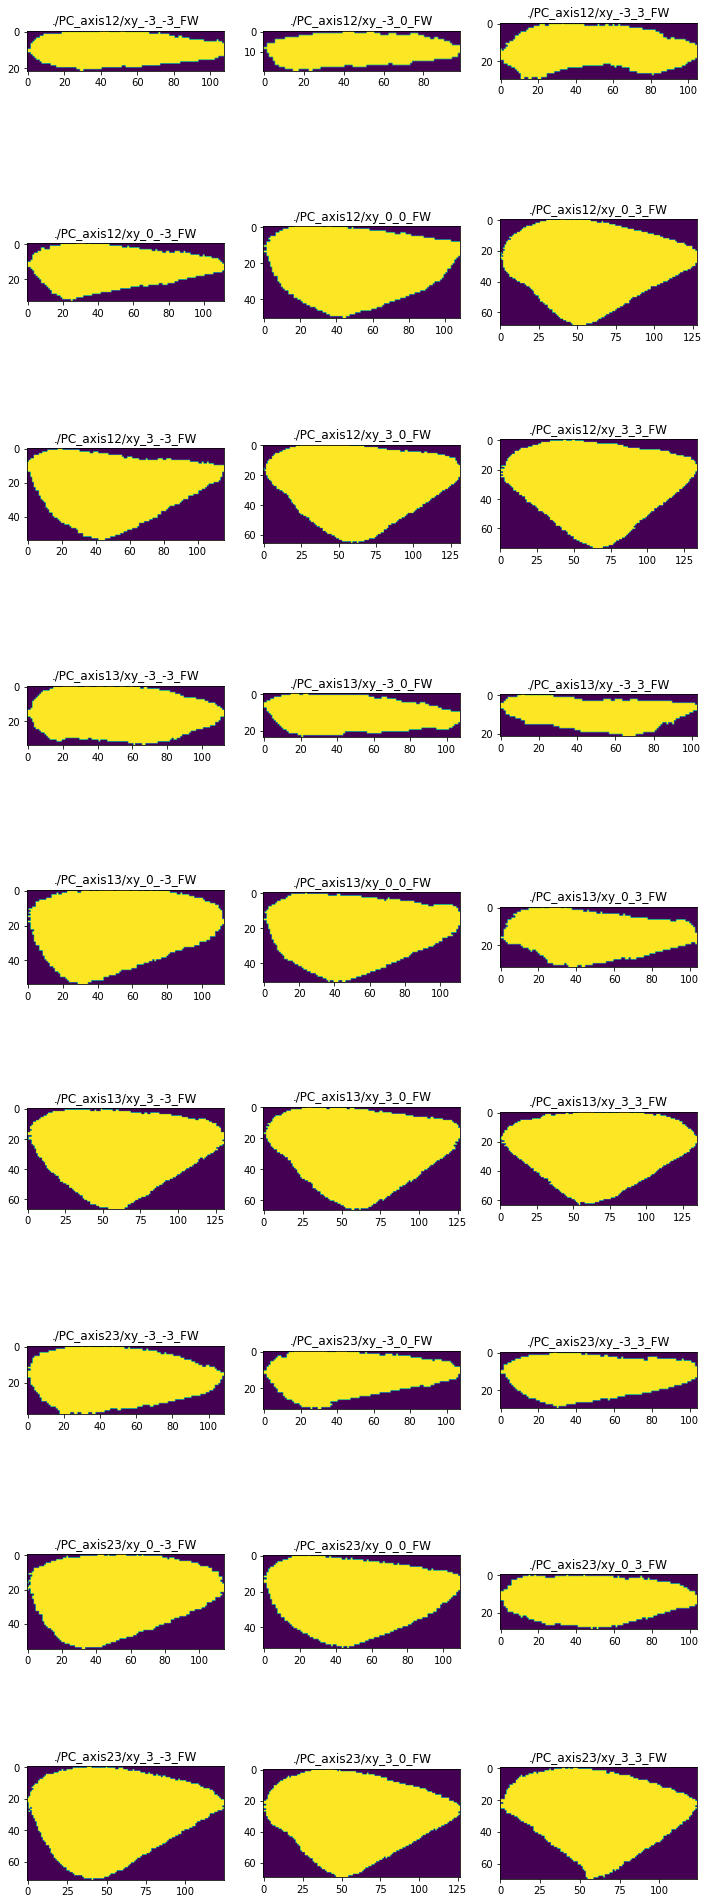

In [40]:
plt.rcParams['figure.figsize'] = [12, 36]

fig, axes = plt.subplots(9, 3)
aspect_ratios = []
nd_second_moment_of_areas_root_on_left = []
nd_second_moment_of_areas_root_on_right = []

for i in range(len(png_files)):
    im = cv2.imread(f'{png_files[i]}', cv2.IMREAD_UNCHANGED)
    im_binary = 255 - (binarify(im) * 255).astype(np.uint8)

    im_binary_idx = np.array(np.where(im_binary == 0)).T

    pca = PCA()

    im_pca_idx = pca.fit_transform(im_binary_idx)

    span_y = int(np.round(im_pca_idx[:,0].max())) - int(np.round(im_pca_idx[:,0].min())) + 1
    span_x = int(np.round(im_pca_idx[:,1].max())) - int(np.round(im_pca_idx[:,1].min())) + 1
    im_pca_binary = np.zeros((span_y, span_x), dtype=np.uint8)

    im_pca_binary_y_idx = np.round(im_pca_idx[:,0]).astype(int) - int(np.round(im_pca_idx[:,0].min()))
    im_pca_binary_x_idx = np.round(im_pca_idx[:,1]).astype(int) - int(np.round(im_pca_idx[:,1].min()))

    kernel = (1,1)
    im_pca_binary[im_pca_binary_y_idx, im_pca_binary_x_idx] = 255
    im_pca_binary = cv2.erode(cv2.dilate(im_pca_binary, kernel, iterations=1), kernel, iterations=1)

    # rotation
    max_y_at_y_idx = max(im_pca_binary_y_idx)
    min_y_at_y_idx = min(im_pca_binary_y_idx)
    max_y_at_x_idx = np.median(im_pca_binary_x_idx[np.where(im_pca_binary_y_idx == max_y_at_y_idx)[0]]).astype(int)
    min_y_at_x_idx = np.median(im_pca_binary_x_idx[np.where(im_pca_binary_y_idx == min_y_at_y_idx)[0]]).astype(int)    
    
    dy, dx = np.array([max_y_at_y_idx, max_y_at_x_idx]) - np.array([min_y_at_y_idx, min_y_at_x_idx])
    tanx = dx / dy
    degree_to_rotate = np.arctan(tanx) / 2 / np.pi * 360
    
    im_pca_binary_rotated = np.array(Image.fromarray(im_pca_binary).rotate(-degree_to_rotate, Image.NEAREST, expand = 1))
    
    im_pca_binary_rotated = im_pca_binary_rotated[np.where(im_pca_binary_rotated == 255)[0].min():np.where(im_pca_binary_rotated == 255)[0].max()+1, :]
    im_pca_binary_rotated = im_pca_binary_rotated[:, np.where(im_pca_binary_rotated == 255)[1].min():np.where(im_pca_binary_rotated == 255)[1].max()+1]
    
    axes[i//3, i%3].imshow(im_pca_binary_rotated.T)
    axes[i//3, i%3].set_title(f'{png_files[i][:-4]}')

    # aspect_ratio = 2 * length / area
    wing_length = im_pca_binary_rotated.shape[0]
    wing_area = len(np.where(im_pca_binary_rotated == 255)[0])
    aspect_ratio = 2 * wing_length**2 / wing_area
    aspect_ratios.append(aspect_ratio)
    #aspect_ratio

    weighted_pixel_counts_root_on_left = 0
    weighted_pixel_counts_root_on_right = 0

    for y_idx, x_idx in zip(*np.where(im_pca_binary_rotated == 255)):
        weighted_pixel_counts_root_on_left += y_idx ** 2
        weighted_pixel_counts_root_on_right += (wing_length - 1 - y_idx) ** 2

    nd_second_moment_of_area_root_on_left = (weighted_pixel_counts_root_on_left / (wing_area * wing_length**2)) ** 0.5
    nd_second_moment_of_area_root_on_right = (weighted_pixel_counts_root_on_right / (wing_area * wing_length**2)) ** 0.5
    nd_second_moment_of_areas_root_on_right.append(nd_second_moment_of_area_root_on_right)
    nd_second_moment_of_areas_root_on_left.append(nd_second_moment_of_area_root_on_left)

    # if hflip:
    #     nd_second_moment_of_areas_final.append(nd_second_moment_of_area_hflip)
    # else:
    #     nd_second_moment_of_areas_final.append(nd_second_moment_of_area)

# plt.savefig('fore_wing_geometry.png')
# plt.savefig('fore_wing_geometry.pdf')

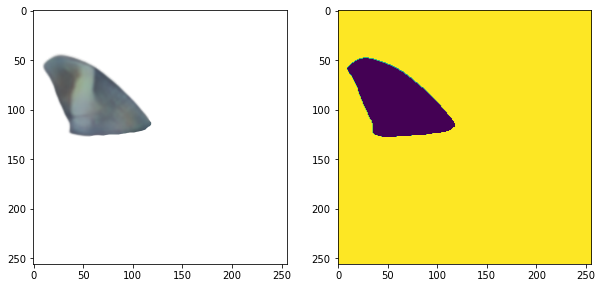

In [41]:
plt.rcParams['figure.figsize'] = [10, 20]
fig_ims, ims_axes = plt.subplots(1,2)
ims_axes[0].imshow(im)
ims_axes[1].imshow(im_binary)

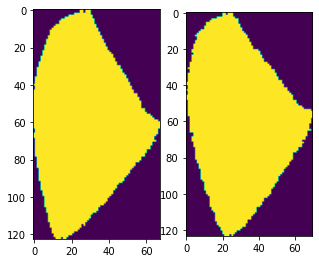

In [42]:
plt.rcParams['figure.figsize'] = [5, 5]
fig_ims, ims_axes = plt.subplots(1,2)
ims_axes[0].imshow(im_pca_binary)
ims_axes[1].imshow(im_pca_binary_rotated)

In [43]:
import pandas as pd

In [44]:
second_moa = pd.DataFrame({'img_file':png_files, 'aspect_ratio':aspect_ratios, 'nd2ndMoA_root_on_left': nd_second_moment_of_areas_root_on_left, 'nd2ndMoA_root_on_right': nd_second_moment_of_areas_root_on_right})

In [45]:
second_moa

,img_file,aspect_ratio,nd2ndMoA_root_on_left,nd2ndMoA_root_on_right
0,./PC_axis12/xy_-3_-3_FW.png,13.626168,0.535562,0.580528
1,./PC_axis12/xy_-3_0_FW.png,13.951601,0.538693,0.575979
2,./PC_axis12/xy_-3_3_FW.png,10.189464,0.543615,0.578861
3,./PC_axis12/xy_0_-3_FW.png,11.037396,0.502035,0.607176
4,./PC_axis12/xy_0_0_FW.png,6.181582,0.527037,0.577315
5,./PC_axis12/xy_0_3_FW.png,5.853519,0.516144,0.580158
6,./PC_axis12/xy_3_-3_FW.png,6.918252,0.497943,0.602020
7,./PC_axis12/xy_3_0_FW.png,6.090178,0.537816,0.559860
8,./PC_axis12/xy_3_3_FW.png,5.767143,0.537764,0.556211
9,./PC_axis13/xy_-3_-3_FW.png,8.833622,0.530682,0.579952


In [46]:
wing_geo_chars = {'pc1':[], 'pc2':[], 'pc3':[], 'aspect_ratio':[], '2nd_movement_of_area':[]}

In [47]:
wing_geo_chars

{'pc1': [],
 'pc2': [],
 'pc3': [],
 'aspect_ratio': [],
 '2nd_movement_of_area': []}

In [48]:
for _, row in second_moa.iterrows():
    f = row.img_file
    pc1, pc2, pc3 = 0, 0, 0
    aspect_ratio = row.aspect_ratio
    nd2ndMoA = row.nd2ndMoA_root_on_right
    if f.split('/')[1].endswith('axis12'):
        pc1, pc2 = f.split('_')[2:4]
    elif f.split('/')[1].endswith('axis13'):
        pc1, pc3 = f.split('_')[2:4]
    elif f.split('/')[1].endswith('axis23'):
        pc2, pc3 = f.split('_')[2:4]
    pc1 = int(pc1)
    pc2 = int(pc2)
    pc3 = int(pc3)
    wing_geo_chars['pc1'].append(pc1)
    wing_geo_chars['pc2'].append(pc2)
    wing_geo_chars['pc3'].append(pc3)
    wing_geo_chars['aspect_ratio'].append(aspect_ratio)
    wing_geo_chars['2nd_movement_of_area'].append(nd2ndMoA)

In [49]:
fw_characters = pd.read_csv('supplementary_materials/fw_characters_20230518.csv', sep='\t')

In [50]:
fw_characters_all = fw_characters.merge(pd.DataFrame(wing_geo_chars), on=['pc1', 'pc2', 'pc3'])

In [51]:
fw_characters_all

,pc1,pc2,pc3,color_saturation,color_brightness,color_richness,color_evenness,rgb_red,rgb_green,rgb_blue,distinctive_from_wing_base,perimeter_over_area,box_aspect_ratio,aspect_ratio,2nd_movement_of_area
0,-3,-3,0,63.658480,122.882456,13,0.704505,133.609942,121.619298,101.323392,6.754081,0.147430,5.095238,13.626168,0.580528
1,-3,0,0,65.074627,139.812367,10,0.661647,155.872779,136.221038,116.169154,3.964249,0.163289,5.105263,13.951601,0.575979
2,-3,0,0,65.074627,139.812367,10,0.661647,155.872779,136.221038,116.169154,3.964249,0.163289,5.105263,12.609730,0.587603
3,-3,0,0,59.213523,140.495255,13,0.605690,155.071174,137.211744,119.196323,4.789099,0.151780,5.000000,13.951601,0.575979
4,-3,0,0,59.213523,140.495255,13,0.605690,155.071174,137.211744,119.196323,4.789099,0.151780,5.000000,12.609730,0.587603
5,-3,3,0,44.204640,190.101624,12,0.771511,200.873782,189.312297,166.012993,9.399166,0.120602,2.525000,10.189464,0.578861
6,0,-3,0,82.826318,119.521489,10,0.725559,135.136464,116.956136,91.806380,7.575291,0.116284,3.272727,11.037396,0.607176
7,0,-3,0,82.826318,119.521489,10,0.725559,135.136464,116.956136,91.806380,7.575291,0.116284,3.272727,10.470377,0.601067
8,0,-3,0,83.384904,118.931083,10,0.723524,134.638537,116.331458,91.149086,7.105732,0.118817,3.322581,11.037396,0.607176
9,0,-3,0,83.384904,118.931083,10,0.723524,134.638537,116.331458,91.149086,7.105732,0.118817,3.322581,10.470377,0.601067


<AxesSubplot:xlabel='aspect_ratio', ylabel='box_aspect_ratio'>

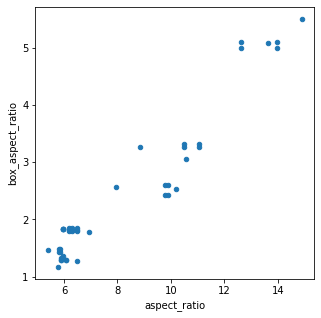

In [52]:
fw_characters_all.plot.scatter(y='box_aspect_ratio', x='aspect_ratio')

In [53]:
fw_characters_all.to_csv('supplementary_materials/fw_characters_all_20230518.csv', index=False, sep='\t')

In [54]:
hw_chars = pd.read_csv('supplementary_materials/hw_characters_20230518.csv', sep='\t')

In [55]:
fam_meta = pd.read_csv('fam_in_2019_gbif_WUver2_20220513.csv', sep=',')
fam_meta

,sn,family,Goldstein2017,sp_count_on_gbif,out_group,no_sp_id,family_sp_count_with_photo,6groups,10groups,fam_mean_PC1,fam_mean_PC2,fam_mean_PC3
0,1,Hydroptilidae,NaN,2088,1,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Phryganeidae,NaN,130,1,0,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Helicopsychidae,NaN,269,1,0,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Leptoceridae,NaN,1826,1,0,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Hydropsychidae,NaN,1683,1,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
78,79,Brahmaeidae,65.0,53,0,0,6.0,4.0,7.0,1.852066,0.333802,-0.676257
79,80,Eupterotidae,339.0,434,0,0,21.0,4.0,7.0,1.604746,0.604990,-0.177330
80,81,Endromidae,59.0,17,0,0,9.0,4.0,6.0,1.907484,0.926427,0.185057
81,82,Saturniidae,2349.0,3128,0,0,302.0,4.0,6.0,1.445788,1.048360,0.289762


In [56]:
target_measurements_no_proxy_area = [
    'color_saturation',
    'color_brightness',
    'color_richness',
    'color_evenness',
    'rgb_red',
    'rgb_green',
    'rgb_blue',
    'distinctive_from_wing_base',
    'perimeter_over_area',
    'box_aspect_ratio',
    'aspect_ratio',
    '2nd_movement_of_area']
target_axes = [f'pc{a}' for a in [1,2,3]]

154.62570978251182
179.68910993730563
23.5
0.8112421444434055
194.905648608713
177.92775753443254
156.63299253035987
21.173793050360228
0.1935566162845756
5.0625
Probably no matched character found in the hind wing.
14.88982456140351
Probably no matched character found in the hind wing.
0.607175782971123
154.62570978251182
179.68910993730563
23.5
0.8112421444434055
194.905648608713
177.92775753443254
156.63299253035987
21.173793050360228
0.1935566162845756
5.0625
Probably no matched character found in the hind wing.
14.88982456140351
Probably no matched character found in the hind wing.
0.607175782971123
154.62570978251182
179.68910993730563
23.5
0.8112421444434055
194.905648608713
177.92775753443254
156.63299253035987
21.173793050360228
0.1935566162845756
5.0625
Probably no matched character found in the hind wing.
14.88982456140351
Probably no matched character found in the hind wing.
0.607175782971123


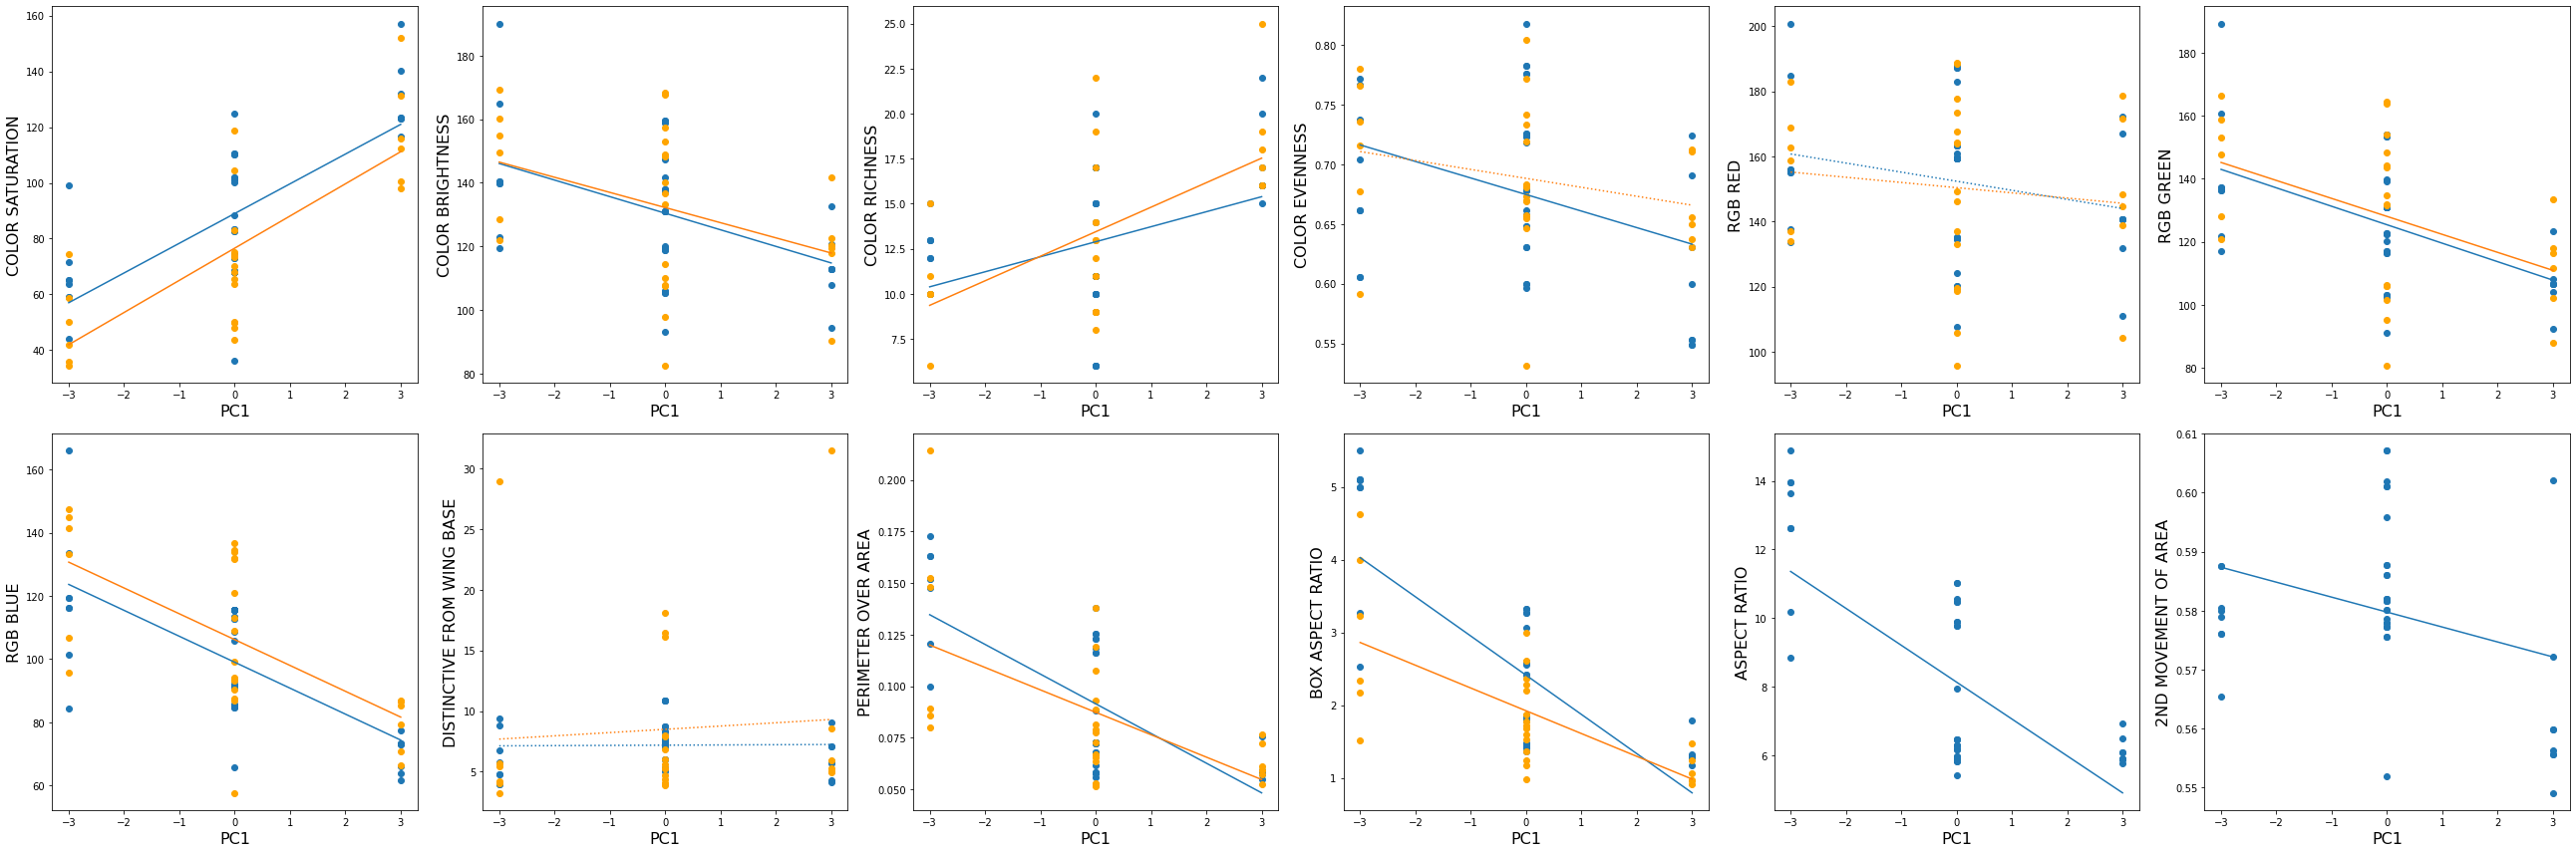

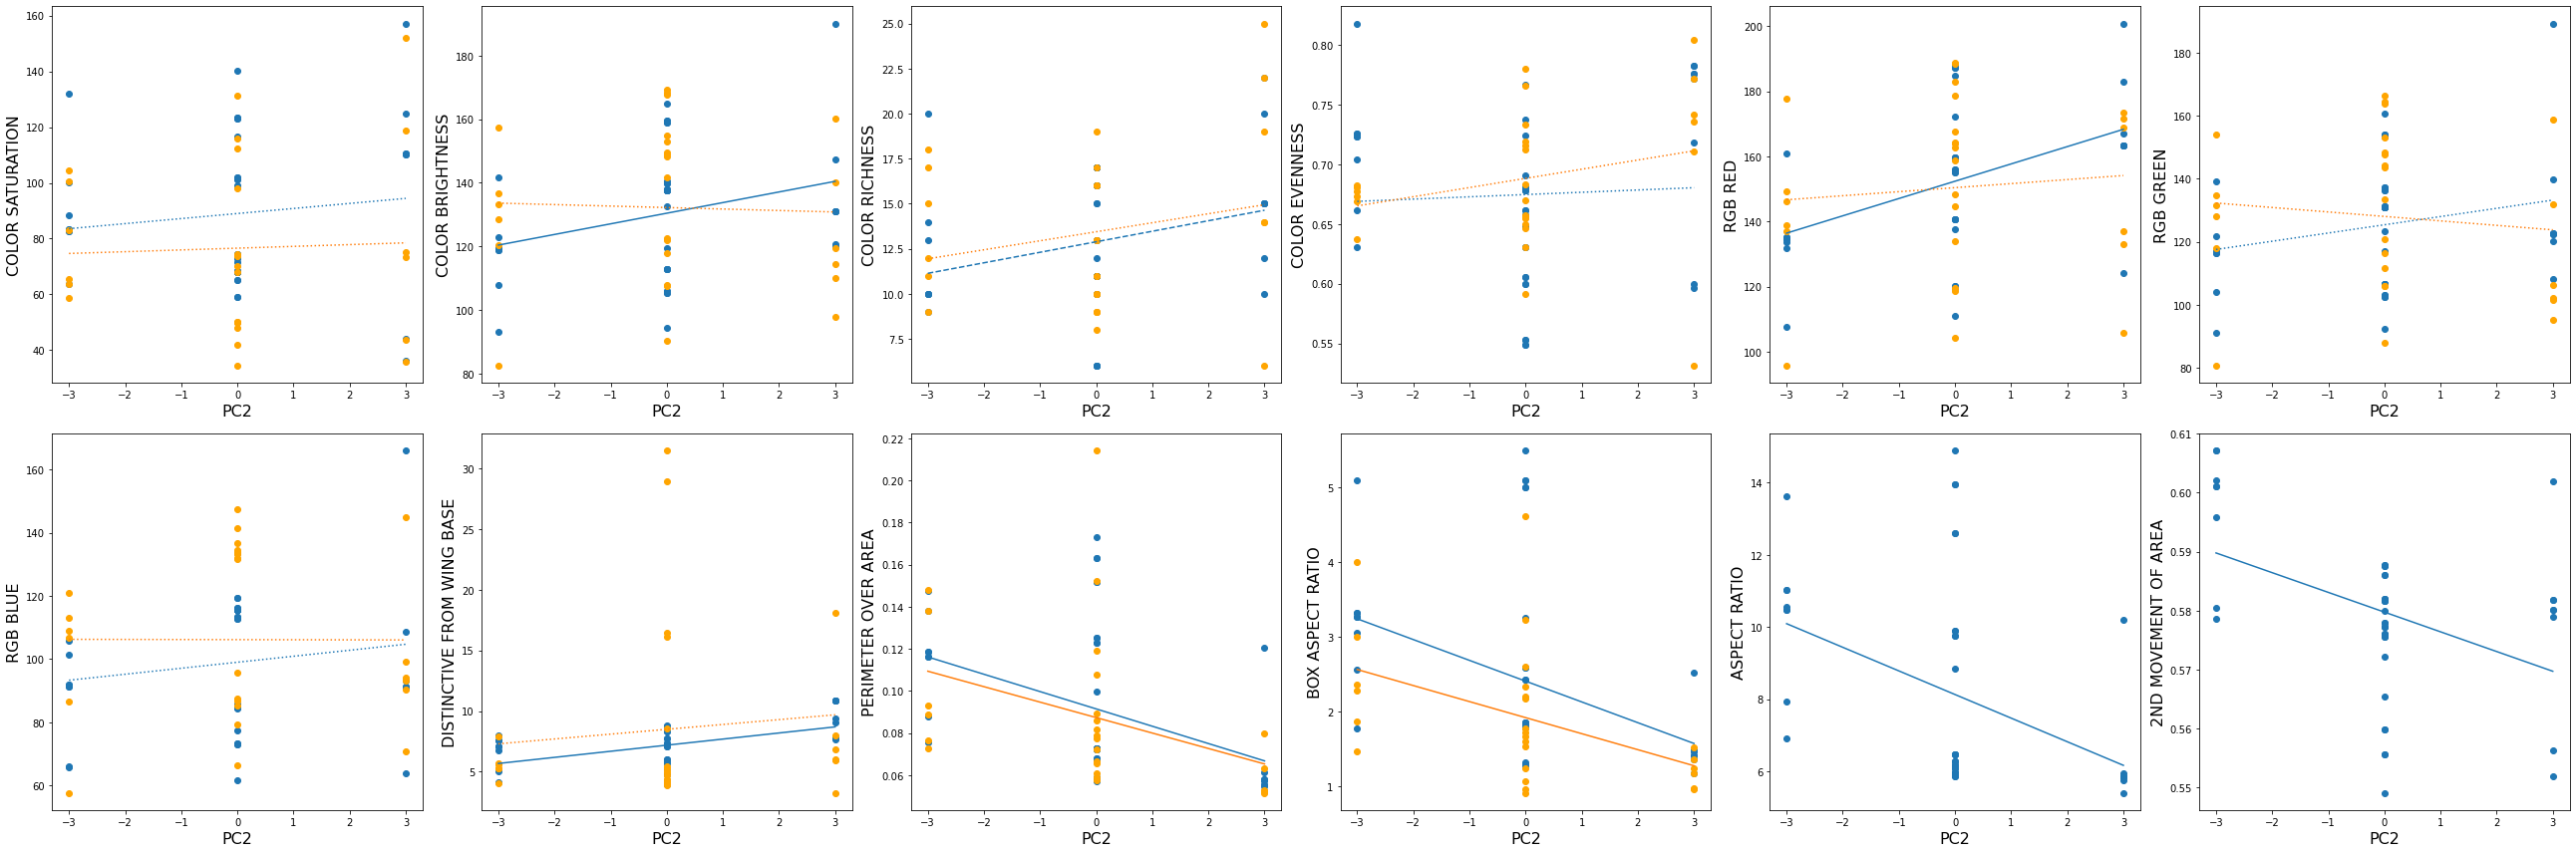

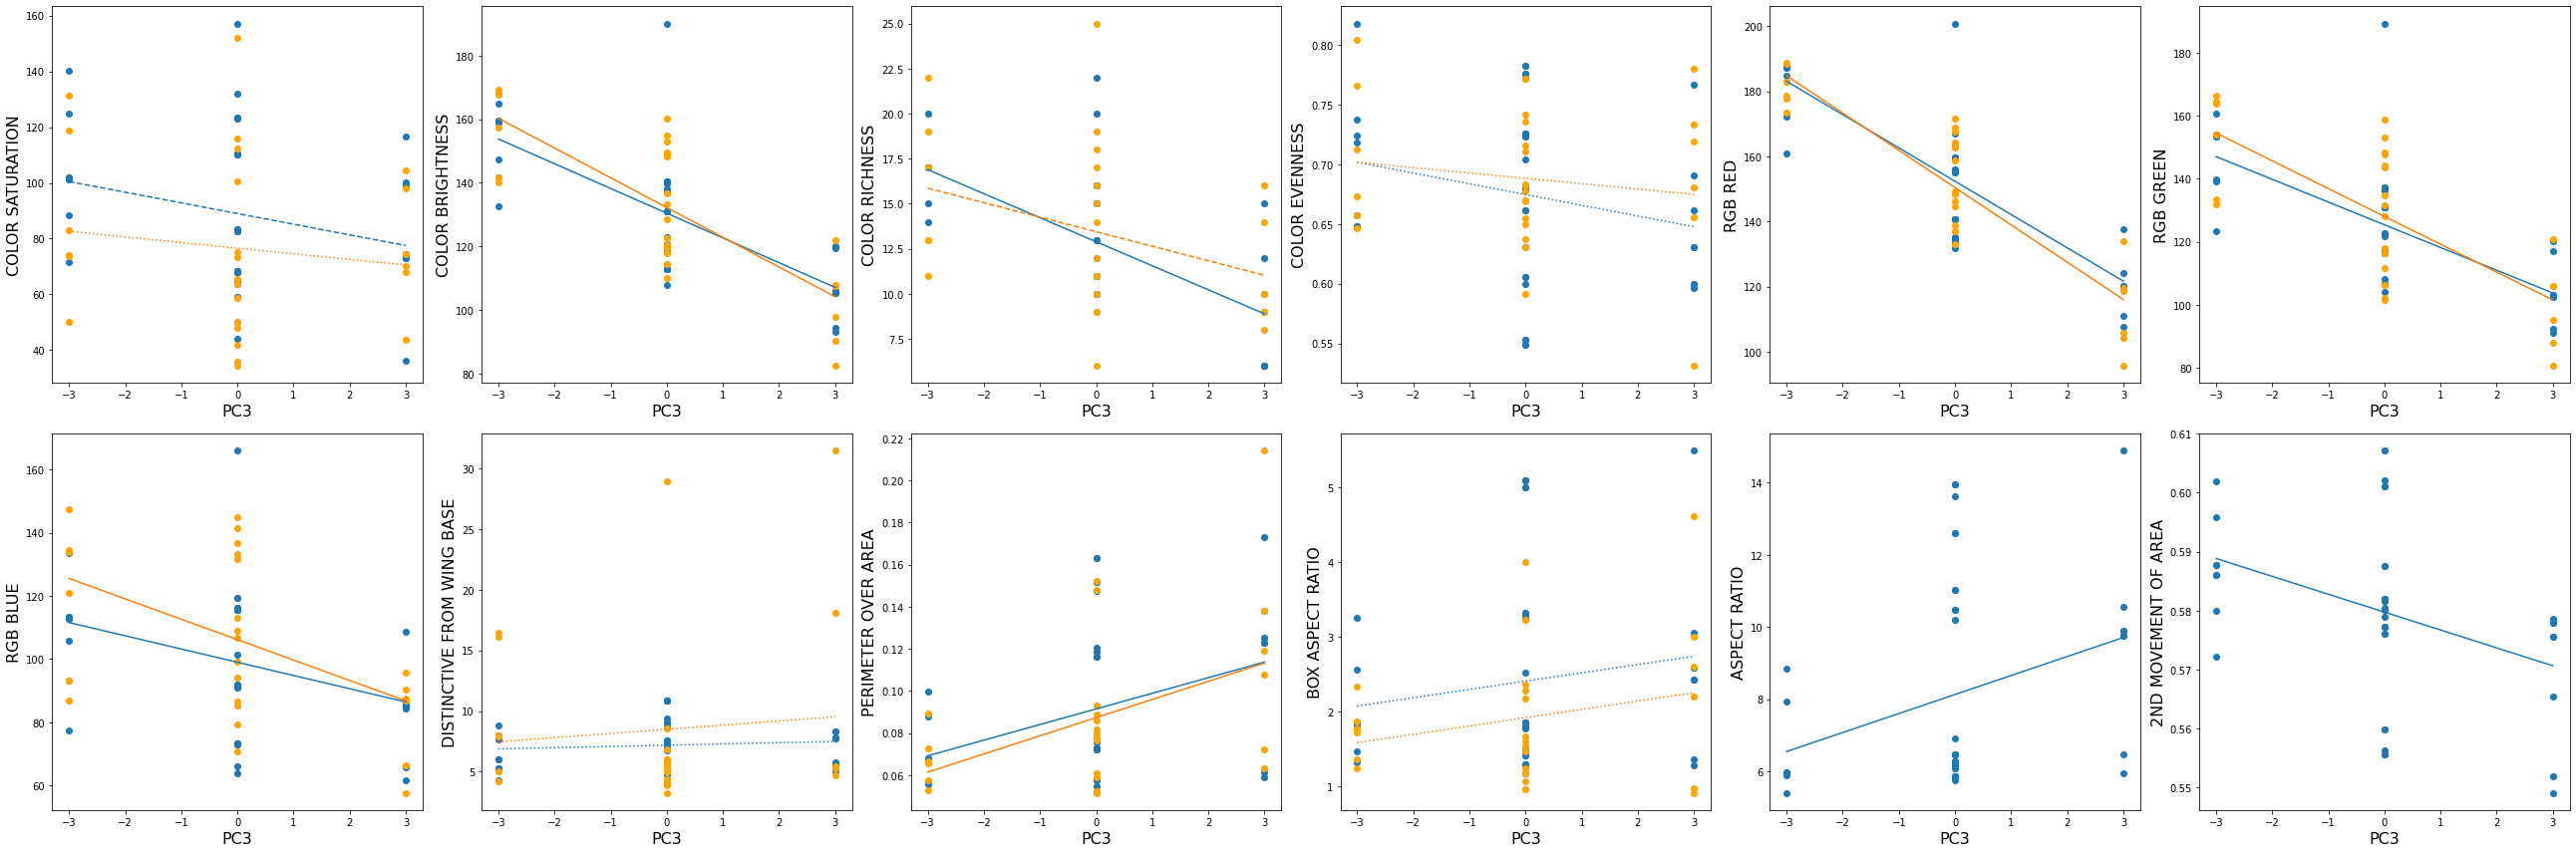

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
import matplotlib as mpl

plt.rcParams['figure.figsize'] = [36, 12]
mpl.rcParams['pdf.fonttype'] = 42

# wing_fig_, wing_axes_ = plt.subplots(27, 3)

n_subplot_y = 2
n_subplot_x = 6

canvas_pcgroups_lm = [
    plt.subplots(n_subplot_y, n_subplot_x),
    plt.subplots(n_subplot_y, n_subplot_x),
    plt.subplots(n_subplot_y, n_subplot_x)
]

rows_ = []
#plt.rcParams['figure.figsize'] = [5, 5]
for target_axis in target_axes:
    for key_id_, key in enumerate(target_measurements_no_proxy_area):
        
        max_y_fw = None
        max_y_hw = None

        block_x_shift = int(target_axis[-1]) - 1
        axis_ = canvas_pcgroups_lm[block_x_shift][1][int(key_id_//n_subplot_x)][int(key_id_%n_subplot_x)]
        
        lm = LinearRegression()
        X = fw_characters_all[[target_axis]]
        y = fw_characters_all[key]
        max_y_fw = np.max(y)
        lm.fit(X, y)
        r_squared = lm.score(X, y)
        adj_r_squared = r_squared - (1 - r_squared) * (X.shape[1] / (X.shape[0] - X.shape[1] - 1))
        Fstat, p = f_regression(X, y)
        sig = ''
        linestyle = 'dotted'
        if p[0] < 1e-3:
            sig = '***'
            linestyle = 'solid'
        elif p[0] < 1e-2:
            sig = '**'
            linestyle = 'solid'
        elif p[0] < 5e-2:
            sig = '*'
            linestyle = 'solid'
        elif p[0] < 1e-1:
            sig = '.'
            linestyle = 'dashed'
            
        rows_.append(['FW', target_axis, key, lm.intercept_, lm.coef_[0], p[0], sig, r_squared, adj_r_squared, Fstat[0]])
            
        axis_.scatter(X, y)
        # axis_.text(x=-3, y=np.max([fw_chars[key], hw_chars[key]]), s=f'p={p[0]:.04f} {sig}, r2={r_squared:.02f}, adj_r2={adj_r_squared:0.2f}', color='tab:blue', fontsize=16)
        axis_.plot([-3, 3], [-3 * lm.coef_[0] + lm.intercept_, 3 * lm.coef_[0] + lm.intercept_], color='tab:blue', linestyle=linestyle)

        ##############################
        
        try:
            lm = LinearRegression()
            X = hw_chars[[target_axis]]
            y = hw_chars[key]
            max_y_hw = np.max(y)
            lm.fit(X, y)
            r_squared = lm.score(X, y)
            adj_r_squared = r_squared - (1 - r_squared) * (X.shape[1] / (X.shape[0] - X.shape[1] - 1))
            Fstat, p = f_regression(X, y)
            sig = ''
            linestyle = 'dotted'
            if p[0] < 1e-3:
                sig = '***'
                linestyle = 'solid'
            elif p[0] < 1e-2:
                sig = '**'
                linestyle = 'solid'
            elif p[0] < 5e-2:
                sig = '*'
                linestyle = 'solid'
            elif p[0] < 1e-1:
                sig = '.'
                linestyle = 'dashed'
                
            rows_.append(['HW', target_axis, key, lm.intercept_, lm.coef_[0], p[0], sig, r_squared, adj_r_squared, Fstat[0]])

            axis_.scatter(X, y, c='orange')
            # axis_.set_ylabel(key.upper())
            # axis_.set_xlabel(target_axis.upper())
            # axis_.set_title(f'p={p[0]:.04f} {sig}, r2={r_squared:.02f}, adj_r2={adj_r_squared:0.2f}')
            #axis_.set_title(key.upper())

            #txt_y_shift = (np.max([fw_chars[key], hw_chars[key]]) - np.min([fw_chars[key], hw_chars[key]])) / 20
            #axis_.text(x=-3, y=np.max([fw_chars[key], hw_chars[key]]) - txt_y_shift, s=f'p={p[0]:.04f} {sig}, r2={r_squared:.02f}, adj_r2={adj_r_squared:0.2f}', color='tab:orange', fontsize=16)
            axis_.plot([-3, 3], [-3 * lm.coef_[0] + lm.intercept_, 3 * lm.coef_[0] + lm.intercept_], color='tab:orange', linestyle=linestyle)
        except:
            print('Probably no matched character found in the hind wing.')
            pass
        
        axis_.set_ylabel(key.upper().replace('_', ' '), fontsize=16)
        axis_.set_xlabel(target_axis.upper(), fontsize=16)

    ######################

#     if False:
#         block_x_shift = int(target_axis[-1]) - 1
#         axis_ = canvas_pcgroups_lm[block_x_shift][1][2][3]

#         lm = LinearRegression()
#         X = fw_hw_area_ratio_df[[target_axis]]
#         y = fw_hw_area_ratio_df['fw_hw_area_ratio']
#         lm.fit(X, y)
#         r_squared = lm.score(X, y)
#         adj_r_squared = r_squared - (1 - r_squared) * (X.shape[1] / (X.shape[0] - X.shape[1] - 1))
#         Fstat, p = f_regression(X, y)
#         sig = ''
#         linestyle = 'dotted'
#         if p[0] < 1e-3:
#             sig = '***'
#             linestyle = 'solid'
#         elif p[0] < 1e-2:
#             sig = '**'
#             linestyle = 'solid'
#         elif p[0] < 5e-2:
#             sig = '*'
#             linestyle = 'solid'
#         elif p[0] < 1e-1:
#             sig = '.'
#             linestyle = 'dashed'

#         axis_.scatter(X, y, c='tab:green')
#         # axis_.set_ylabel('fw_hw_area_ratio'.upper())
#         # axis_.set_xlabel(target_axis.upper())
#         # axis_.set_title(f'p={p[0]:.04f} {sig}, r2={r_squared:.02f}, adj_r2={adj_r_squared:0.2f}')
#         axis_.set_title('fw_hw_area_ratio'.upper())
        if max_y_hw is None:
            y_pos = max_y_fw
        else:
            y_pos = (max_y_fw + max_y_hw) / 2
        print(y_pos)
        # axis_.text(x=-3, y=y_pos, s=f'p={p[0]:.04f} {sig}, r2={r_squared:.02f}, adj_r2={adj_r_squared:0.2f}', color='tab:green')
        # axis_.plot([-3, 3], [-3 * lm.coef_[0] + lm.intercept_, 3 * lm.coef_[0] + lm.intercept_], color='green', linestyle=linestyle)

    #canvas_pcgroups_lm[block_x_shift][0].suptitle(target_axis.upper(), size=24)
    canvas_pcgroups_lm[block_x_shift][0].tight_layout()
    canvas_pcgroups_lm[block_x_shift][0].savefig(f'./supplementary_materials/aw/aw_LM-{target_axis}_no_stats.pdf')

In [58]:
wing_characters_stats = pd.DataFrame(rows_, columns=['wing', 'axis', 'character', 'lm_alpha', 'lm_beta', 'p', 'sig', 'r2', 'adj_r2', 'F'])

In [59]:
wing_characters_stats

,wing,axis,character,lm_alpha,lm_beta,p,sig,r2,adj_r2,F
0,FW,pc1,color_saturation,89.008278,10.652992,3.812740e-08,***,0.508869,0.497447,44.553042
1,HW,pc1,color_saturation,76.594378,11.527133,3.530164e-06,***,0.583661,0.567007,35.047171
2,FW,pc1,color_brightness,130.443430,-5.212750,8.802835e-04,***,0.229134,0.211207,12.781434
3,HW,pc1,color_brightness,132.224580,-4.763618,3.952416e-02,*,0.158779,0.125130,4.718705
4,FW,pc1,color_richness,12.888889,0.833333,6.832143e-03,**,0.158117,0.138538,8.075960
...,...,...,...,...,...,...,...,...,...,...
61,HW,pc3,perimeter_over_area,0.087375,0.008630,1.516091e-02,*,0.213823,0.182376,6.799444
62,FW,pc3,box_aspect_ratio,2.411066,0.110956,2.916148e-01,,0.025826,0.003171,1.139978
63,HW,pc3,box_aspect_ratio,1.922499,0.111510,2.204819e-01,,0.059417,0.021794,1.579267
64,FW,pc3,aspect_ratio,8.131018,0.526192,2.312593e-02,*,0.114290,0.093692,5.548632


In [60]:
wing_characters_stats.to_csv(f'./supplementary_materials/wing_characters_stats_20230518.csv', index=False, sep='\t')